In [3]:
import torch
import numpy as np
import pickle
import matplotlib.pylab as plt
import sys
sys.path.append("C:/Users/lenovo/Desktop/spliking_nn_for_brain_simulation-master")
import os
import time
import random_initialize as ri

ModuleNotFoundError: No module named 'random_initialize'

In [3]:
with open('1000_Ca_signal_500ms.pickle','rb+') as f:
    Y=pickle.load(f)
with open('1000_Ca_signal_500ms2.pickle','rb+') as f:
    Ct=pickle.load(f)
with open('1000_Ca_signal_property.pickle','rb+') as f:
    Ca_property=pickle.load(f)

In [4]:
torch.set_default_tensor_type(torch.FloatTensor)
if torch.cuda.is_available():
    #device = torch.device("cuda")
    device = torch.device("cpu")

In [5]:
#导入节点信息与连接信息
path = 'C:/Users/lenovo/Desktop/spliking_nn_for_brain_simulation-master/single_small_test/single'
property, w_uij = ri.connect_for_block(path)
N, K=1,1000
property = property.reshape([N * K, -1])

torch.Size([1000, 22]) torch.Size([4, 1000, 1000])


In [6]:
real_gu_i = property[:,10:14].mean(axis=0)#获取正确的gu_i

In [7]:
class block:
    def __init__(self, node_property, w_uij, delta_t=1):
        # A block is a set of spliking neurals with inner full connections, we consider 4 connections:
        # AMPA, NMDA, GABAa and GABAb
        # shape note:
        #
        # N: numbers of neural cells
        # K: connections kind, = 4 (AMPA, NMDA, GABAa and GABAb)
        assert len(w_uij.shape) == 3
        N = w_uij.shape[1]#神经元的数量
        K = w_uij.shape[0]#K=4，4种神经递质

        self.w_uij = w_uij  # shape [K, N, N] #w_uij[a,b,c]->c号神经元对b号神经元的a种神经递质的连接权值
        self.delta_t = delta_t

        self.update_property(node_property)

        self.t_ik_last = torch.zeros([N], device=self.w_uij.device) # shape [N]
        self.V_i = torch.ones([N], device=self.w_uij.device) * (self.V_th + self.V_reset)/2  # membrane potential, shape: [N]
        self.J_ui = torch.zeros([K, N], device=self.w_uij.device)  # shape [K, N]
        self.t = torch.tensor(0., device=self.w_uij.device)  # scalar

        self.update_I_syn()

    @staticmethod
    def expand(t, size):
        t = torch.tensor(t)
        shape = list(t.shape) + [1] * (len(size) - len(t.shape))
        return t.reshape(shape).expand(size)

    def update_J_ui(self, delta_t, active):
        # active shape: [N], dtype bool
        # t is a scalar
        self.J_ui = self.J_ui * torch.exp(-delta_t / self.tau_ui)
        J_ui_activate_part = self.bmm(self.w_uij, active.float()) # !!! this part can be sparse.
        self.J_ui += J_ui_activate_part
        pass

    @staticmethod
    def bmm(H, b):
        if isinstance(H, torch.sparse.FloatTensor):#torch.sparse.Tensor
            return torch.stack([torch.sparse.mm(H[i], b.unsqueeze(1)).squeeze(1) for i in range(4)])
        else:
            return torch.matmul(H, b.unsqueeze(0).unsqueeze(2)).squeeze(2)

    def update_I_syn(self):
        self.I_ui = self.g_ui * (self.V_ui - self.V_i) * self.J_ui
        # [K, N]            [K, N] - [K, 1]
        self.I_syn = self.I_ui.sum(dim=0)
        pass

    def update_Vi(self, delta_t):
        main_part = -self.g_Li * (self.V_i - self.V_L)
        C_diff_Vi = main_part + self.I_syn + self.I_extern_Input
        delta_Vi = delta_t / self.C * C_diff_Vi

        Vi_normal = self.V_i + delta_Vi

        # if t < self.t_ik_last + self.T_ref:
        #   V_i = V_reset
        # else:
        #   V_i = Vi_normal
        is_not_saturated = (self.t >= self.t_ik_last + self.T_ref)
        V_i = torch.where(is_not_saturated, Vi_normal, self.V_reset)
        #print(is_not_saturated.sum())
        active = (V_i >= self.V_th)#判断是否激发
        self.V_i = torch.min(V_i, self.V_th)
        return active

    def update_t_ik_last(self, active):
        self.t_ik_last = torch.where(active, self.t, self.t_ik_last)

    def run(self, noise_rate=0.01, isolated=False):
        self.t += self.delta_t#时间步进
        self.active = self.update_Vi(self.delta_t)#状态是否激发
        if not isolated:#孤立设置
            new_active = (torch.rand(self.w_uij.shape[2], device=self.w_uij.device) < noise_rate) | self.active
        else:#非孤立设置
            new_active = (torch.rand(self.w_uij.shape[2], device=self.w_uij.device) < noise_rate)
        self.update_J_ui(self.delta_t, new_active)
        self.update_I_syn()
        self.update_t_ik_last(self.active)

        mean_Vi = []
        sum_activate = []
        for i in range(self.sub_idx.max().int() + 1):
            mean_Vi.append(self.V_i[self.sub_idx == i].mean())
            sum_activate.append(self.active[self.sub_idx == i].float().sum())

        return torch.stack(sum_activate), torch.stack(mean_Vi)

    def update_property(self, node_property):
        # update property
        # column of node_property is
        # E/I, blocked_in_stat, has_extern_Input, no_input, C, g_Li, V_L, V_th, V_reset, g_ui, V_ui, tau_ui
        E_I, blocked_in_stat, I_extern_Input, sub_idx, C, T_ref, g_Li, V_L, V_th, V_reset, g_ui, V_ui, tau_ui = \
            node_property.transpose(0, 1).split([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4])

        self.I_extern_Input = I_extern_Input.squeeze(0) # extern_input index , shape[K]
        self.V_ui = V_ui  # AMPA, NMDA, GABAa and GABAb potential, shape [K, N]
        self.tau_ui = tau_ui  # shape [K, N]
        self.g_ui = g_ui  # shape [K, N]
        self.g_Li = g_Li.squeeze(0)  # shape [N]
        self.V_L = V_L.squeeze(0)  # shape [N]
        self.C = C.squeeze(0)   # shape [N]
        self.sub_idx = sub_idx.squeeze(0) # shape [N]
        self.V_th = V_th.squeeze(0)   # shape [N]
        self.V_reset = V_reset.squeeze(0)  # shape [N]
        self.T_ref = T_ref.squeeze(0) # shape [N]
        return True

    def update_conn_weight(self, conn_idx, conn_weight):
        # update part of conn_weight
        # conn_idx shape is [4, X']
        # conn_weight shape is [X']
        self.w_uij[conn_idx] = conn_weight
        return True

In [13]:
def cov_calculator_tensor(samples,mu,state_size):
    sample_size =  samples.shape[1]
    C = torch.zeros([state_size,state_size],device =device)
    for i in range(sample_size):
        C+=torch.matmul((samples[:,i].reshape(-1,1)-mu),(samples[:,i].reshape(-1,1)-mu).T)
    C = C/(sample_size-1)
    return C
#@jit(nopython=True)
def sigmoid_func(x,a,b):
    assert a<b  
    return (a+b*torch.exp(x))/(1+torch.exp(x))
def sigmoid_func(x,a,b):
    assert a<b  
    return (a*torch.exp(-x)+b)/(1+torch.exp(-x))
#@jit(nopython=True)
def inv_sigmoid_func(x,a,b):
    assert len(x[x<=a])==0 and len(x[x>=b])==0
    #d = (b-a)/1000
    #x[x<=a] = a+d #截断
    #x[x>=b] = b-d #截断
    return torch.log((x-a)/(b-x))

def inv_sigmoid_func_num(x,a,b):
    #assert len(x[x<=a])==0 and len(x[x>=b])==0
    d = (b-a)/1000
    x = a+d if x<=a else x#截断
    x = b-d if x>=b else x#截断
    return torch.log((x-a)/(b-x))

In [125]:
#initialization
#state: gu_1, gu_3, a,b, yj, Y
delta_t =1
T_size = 20
obs_interval=1
state_size = 6
samples_size = 5
V_th = -50;V_reset = -65
mu0=0#mu0=-3
gu_i_C0 = 1**2
C0 = 1**2
ratio = 10;ratio2 = 5
bounds=np.array([[real_gu_i[0]/ratio,real_gu_i[0]*ratio],[real_gu_i[2]/ratio,real_gu_i[2]*ratio],\
                 [Ca_property[0]/ratio2,Ca_property[0]*ratio2],[Ca_property[1]/ratio2,Ca_property[1]*ratio2],\
                 [Ca_property[2]/ratio2,Ca_property[2]*ratio2]])
gu_1_low_bound,gu_1_upper_bound = bounds[0,:]
gu_3_low_bound,gu_3_upper_bound = bounds[1,:]
a_low_bound,a_upper_bound = bounds[2,:]
b_low_bound,b_upper_bound = bounds[3,:]
yj_low_bound,yj_upper_bound = bounds[4,:]

all_cell_states = torch.zeros([samples_size,K,state_size]) #所有sample的cell的参数全体
all_cell_states[:,:,0] = torch.tensor(np.random.normal(0,gu_i_C0,[samples_size,K])) #gu_1
all_cell_states[:,:,1] = torch.tensor(np.random.normal(0,gu_i_C0,[samples_size,K])) #gu_3
all_cell_states[:,:,2:5] = torch.tensor(np.random.normal(0,C0,[samples_size,K,3]))
all_cell_states[:,:,5] = 0

B_list = []
for sample_index in range(samples_size):
    #初始化各block的神经元状态
    property_=property[:]
    property_[:,10] = sigmoid_func(all_cell_states[sample_index,:,0],gu_1_low_bound,gu_1_upper_bound)
    property_[:,12] = sigmoid_func(all_cell_states[sample_index,:,1],gu_3_low_bound,gu_3_upper_bound)
    B = block(
    node_property=property_,
    w_uij=w_uij,
    delta_t=delta_t,
)
    B_list.append(B)

In [126]:
%%time
#undate
cells_state_size = state_size*K
diag_list = np.ones(cells_state_size)
Sigma_z =np.diag(diag_list**2)
gama = torch.tensor(0.1**2)

gain_weight_ = 0.9
other_gain_weight = (1-gain_weight_)/(K-1)
gain_weight = torch.ones([samples_size,K,state_size])*other_gain_weight

all_sum_activate = torch.zeros([T_size,samples_size])
all_mean_Vi = torch.zeros([T_size,samples_size])
all_mean_Vi[0,:] = (V_th+V_reset)/2
all_Vi = torch.zeros([T_size,samples_size,K])
all_Vi[0,:,:] = (V_th+V_reset)/2
all_Ct = torch.zeros([T_size,samples_size,K])
all_Yt = torch.zeros([T_size,samples_size,K])
H = torch.zeros([1,cells_state_size]);H[0,cells_state_size-1]=1
for t in range(T_size):
    print("t:{}".format(t))
    for sample_index,Block in enumerate(B_list):
        #设置gu_i
        Block.g_ui[0,:] = sigmoid_func(all_cell_states[sample_index,:,0],gu_1_low_bound,gu_1_upper_bound)
        Block.g_ui[2,:] = sigmoid_func(all_cell_states[sample_index,:,1],gu_3_low_bound,gu_3_upper_bound)
        print( sigmoid_func(all_cell_states[sample_index,0:5,0],gu_1_low_bound,gu_1_upper_bound))
        #更新系统状态
        sum_activate, mean_Vi = Block.run(noise_rate=0.007)
        #收集统计信息
        all_sum_activate[t,sample_index] = sum_activate
        all_mean_Vi[t,sample_index] = mean_Vi
        all_Vi[t,sample_index,:] = Block.V_i

        if t%obs_interval==0:#观测节点
            a = sigmoid_func(all_cell_states[sample_index,1,2],a_low_bound,a_upper_bound)###所有cell共享一个a,b,yj
            b = sigmoid_func(all_cell_states[sample_index,1,3],b_low_bound,b_upper_bound)
            yj = sigmoid_func(all_cell_states[sample_index,1,4],yj_low_bound,yj_upper_bound)
            #a,b,yj=Ca_property
            V_i_j_ = all_Vi[t-obs_interval:t,sample_index,:]
            all_Ct[t,sample_index,:]=yj*all_Ct[t-1,sample_index,:]+(V_i_j_>=V_th).sum(axis=0)
            #Yt=a*(all_Ct[t,sample_index,:]+b)#+epslo[i,:]
            all_Yt[t,sample_index,:] = a*(all_Ct[t,sample_index,:]+b)#+epslo[i,:]
            all_cell_states[sample_index,:,state_size-1] = all_Yt[t,sample_index,:]

    if t%obs_interval==0:#观测节点,Kalman update
        all_gain = 0
        for cell_index in range(K):
            mu_cell = all_cell_states[:,:,:].mean(axis=0).reshape(-1,1)
            all_cell_states_copy = all_cell_states[:,:,:]
            all_cell_states_copy=all_cell_states_copy.reshape(samples_size,-1).T#注意是否存在乱序
            all_cell_states_copy+=torch.tensor(np.random.normal(0,0.02,[cells_state_size,samples_size]))#draw 
            #C_new = cov_calculator_tensor(all_cell_states_copy,mu_cell,cells_state_size)#太慢了
            deviation = all_cell_states_copy-mu_cell
            half_cov = torch.matmul(deviation[-1,:].reshape(-1,samples_size),deviation.T)/(samples_size-1)
            S = torch.matmul(half_cov,H.T)+gama
            K_kf = half_cov.T/S
            if cell_index==1:
                print("K_kf:{}".format(K_kf))
            samples_obs = torch.normal(Y[t,cell_index],gama,[samples_size])#观测量的分析
            gain=torch.matmul(K_kf,(samples_obs - all_cell_states_copy[-1,:]).reshape(1,-1)).reshape([state_size, K, samples_size]).permute(2,1,0)
            gain_weight_copy  = gain_weight[:]
            gain_weight_copy[:,cell_index,:] = gain_weight
            gain*=gain_weight_copy
            all_gain+=gain
        all_gain[all_gain>1]=1;all_gain[all_gain<-1]=-1;
        print("all_gain_max:{}all_gain_min:{}".format(all_gain.max(),all_gain.min()))
        print("S:{}".format(S))
        all_cell_states+=all_gain

t:0
tensor([0.1006, 0.0684, 0.0761, 0.1184, 0.0645])
tensor([0.0303, 0.1826, 0.0974, 0.1113, 0.1403])
tensor([0.1753, 0.0870, 0.0570, 0.0761, 0.1056])
tensor([0.1867, 0.1080, 0.1224, 0.1265, 0.1590])
tensor([0.1182, 0.1175, 0.1183, 0.0146, 0.1127])


RuntimeError: expand(torch.FloatTensor{[5, 1000, 6]}, size=[5, 6]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)

In [119]:
all_cell_states[:,1,0].mean(axis=0)

tensor(nan)

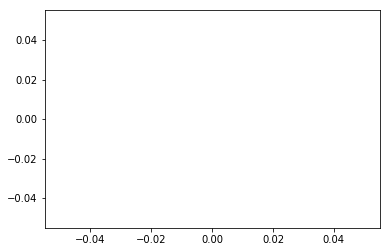

In [120]:
plt.scatter(range(K),sigmoid_func(all_cell_states[:,:,0].mean(axis=0),gu_1_low_bound,gu_1_upper_bound))

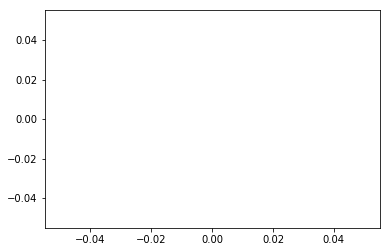

In [121]:
plt.scatter(range(K),sigmoid_func(all_cell_states[:,:,1].mean(axis=0),gu_3_low_bound,gu_3_upper_bound))

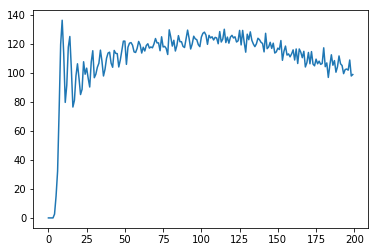

In [122]:
plt.plot(all_sum_activate.mean(axis=1))

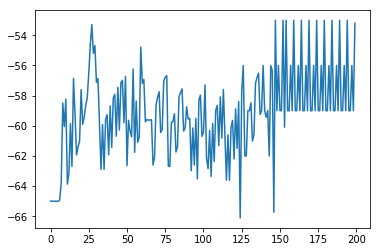

In [123]:
plt.plot(all_Vi[:,:,1].mean(axis=1))

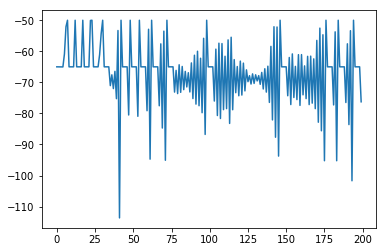

In [124]:
plt.plot(all_Vi[:,1,200])